<a href="https://colab.research.google.com/github/SalsiYari/ImgDatasetGenerator/blob/main/zeroShot_CLIP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
!pip install open_clip_torch --quiet
!pip install scikit-learn matplotlib pandas tqdm --quiet

import torch
print("CUDA:", torch.cuda.is_available())
print("MPS:", torch.backends.mps.is_available())


import argparse
import os
import json
from pathlib import Path
from typing import List, Tuple, Dict

import torch
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, top_k_accuracy_score
)
import matplotlib.pyplot as plt

import open_clip


# -------- Prompt templates (piccolo ensemble) --------
TEMPLATES = [
    "a photo of a {} building",
    "a photograph of {} architecture",
    "an example of {} architecture",
    "a building in {} style",
    "a {} architectural style building",
]

# Opzionale: sinonimi/minor tweaks per aiutare disambiguazioni comuni
STYLE_ALIASES = {
    # "Romanesque": ["Romanesque", "Romanic"],  # se servisse
    # "Gothic": ["Gothic", "Gothic revival"],   # esempio
}


def make_prompts_for_class(cname: str) -> List[str]:
    # usa alias se presenti, altrimenti solo il nome
    variants = STYLE_ALIASES.get(cname, [cname])
    prompts = []
    for v in variants:
        for tmpl in TEMPLATES:
            prompts.append(tmpl.format(v))
    # + forme "architecture" esplicite
    prompts.append(f"{cname} architecture")
    prompts.append(f"{cname} style architecture")
    return list(dict.fromkeys(prompts))  # dedup, preserva ordine


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def build_dataloader(split_dir: str, image_size: int, batch_size: int, num_workers: int):
    # Trasformazioni compatibili con CLIP
    tfm = T.Compose([
        T.Resize(image_size, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                    std=(0.26862954, 0.26130258, 0.27577711)),
    ])
    ds = ImageFolder(split_dir, transform=tfm)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False,
                    num_workers=num_workers, pin_memory=True)
    return ds, dl


@torch.no_grad()
def encode_texts(model, tokenizer, classnames: List[str], device) -> Tuple[torch.Tensor, List[str], List[str]]:
    """
    Ritorna (text_features_norm, classnames, prompts_used)
    text_features_norm: [num_prompts_total, D]
    """
    all_prompts = []
    class_offsets = [0]  # per sapere dove iniziano i prompt di ogni classe
    for cname in classnames:
        prompts = make_prompts_for_class(cname)
        all_prompts.extend(prompts)
        class_offsets.append(len(all_prompts))

    tokens = tokenizer(all_prompts)
    text_features = model.encode_text(tokens.to(device))
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    return text_features, all_prompts, class_offsets


def aggregate_class_logits(logits_per_image: torch.Tensor,
                           class_offsets: List[int],
                           agg: str = "mean") -> torch.Tensor:
    """
    logits_per_image: [B, num_prompts_total]
    Restituisce logits per classe aggregando i prompt della stessa classe → [B, C]
    """
    B = logits_per_image.size(0)
    C = len(class_offsets) - 1
    out = torch.empty(B, C, device=logits_per_image.device)
    for c in range(C):
        s, e = class_offsets[c], class_offsets[c+1]
        slice_logits = logits_per_image[:, s:e]
        if agg == "mean":
            out[:, c] = slice_logits.mean(dim=1)
        elif agg == "max":
            out[:, c] = slice_logits.max(dim=1).values
        else:
            raise ValueError("agg must be 'mean' or 'max'")
    return out


@torch.no_grad()
def run_zeroshot(model, preprocess_size: int, dataloader, classnames: List[str],
                 tokenizer, device, class_offsets: List[int], text_features: torch.Tensor,
                 temperature: float = 100.0, agg: str = "mean"):
    """
    Restituisce:
    - y_true (numpy)
    - y_pred (numpy)
    - probs (numpy)   [N, C]
    - paths (list)
    """
    model.eval()
    y_true, y_pred = [], []
    probs_list = []
    paths = []

    for images, labels in tqdm(dataloader, desc="Inference"):
        images = images.to(device)

        image_features = model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # similarità coseno → logits con una temperatura (opzionale)
        logits = temperature * image_features @ text_features.t()  # [B, num_prompts_total]

        class_logits = aggregate_class_logits(logits, class_offsets, agg=agg)  # [B, C]
        prob = class_logits.softmax(dim=-1)

        pred = class_logits.argmax(dim=-1)

        y_true.extend(labels.tolist())
        y_pred.extend(pred.tolist())
        probs_list.append(prob.detach().cpu().numpy())

        # salva path file (per analisi qualitativa)
        batch_paths = [dataloader.dataset.samples[i][0] for i in range(len(paths), len(paths)+len(labels))]
        paths.extend(batch_paths)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    probs = np.concatenate(probs_list, axis=0)
    return y_true, y_pred, probs, paths


def plot_confusion(cm: np.ndarray, classnames: List[str], out_png: Path):
    fig, ax = plt.subplots(figsize=(max(8, len(classnames) * 0.45), max(6, len(classnames) * 0.45)))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classnames,
        yticklabels=classnames,
        ylabel="True label",
        xlabel="Predicted label",
        title="Confusion Matrix"
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fig.tight_layout()
    fig.savefig(out_png, dpi=200)
    plt.close(fig)


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data-root", type=str, required=True,
                        help="cartella con train/ valid/ test/")
    parser.add_argument("--split", type=str, default="test", choices=["train", "valid", "test"])
    parser.add_argument("--model", type=str, default="ViT-L-14-336")
    parser.add_argument("--pretrained", type=str, default="openai",
                        help="es. openai | laion2b_s32b_b79k | laion2b_s34b_b88k ...")
    parser.add_argument("--batch-size", type=int, default=64)
    parser.add_argument("--num-workers", type=int, default=4)
    parser.add_argument("--agg", type=str, default="mean", choices=["mean", "max"],
                        help="come aggregare i logits dei prompt della stessa classe")
    parser.add_argument("--temperature", type=float, default=100.0)
    parser.add_argument("--topk", type=int, nargs="+", default=[1, 2, 3, 5])
    parser.add_argument("--outdir", type=str, default="zs_results")
    args = parser.parse_args()

    device = get_device()
    print(f"Device: {device}")

    # Carica modello e tokenizer
    model, _, preprocess = open_clip.create_model_and_transforms(
        model_name=args.model, pretrained=args.pretrained, device=device
    )
    tokenizer = open_clip.get_tokenizer(args.model)

    # Determina image_size dalla transform CLIP
    # (open_clip ritorna una Compose, cerchiamo il CenterCrop/Resize target)
    image_size = 224
    for t in preprocess.transforms:
        if isinstance(t, T.CenterCrop):
            image_size = t.size
            break
        if isinstance(t, T.Resize) and isinstance(t.size, int):
            image_size = t.size

    split_dir = os.path.join(args.data_root, args.split)
    ds, dl = build_dataloader(split_dir, image_size, args.batch_size, args.num_workers)
    classnames = ds.classes
    print(f"{args.split=}  num_images={len(ds)}  num_classes={len(classnames)}")

    # Prepara i testi (prompt ensemble)
    text_features, prompts_used, class_offsets = encode_texts(model, tokenizer, classnames, device)
    print(f"Total prompts: {len(prompts_used)}")

    # Inference zero-shot
    y_true, y_pred, probs, paths = run_zeroshot(
        model, image_size, dl, classnames, tokenizer, device,
        class_offsets, text_features, temperature=args.temperature, agg=args.agg
    )

    # Metriche
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Top-K
    topk_results = {}
    for k in args.topk:
        k = min(k, len(classnames))
        topk = top_k_accuracy_score(y_true, probs, k=k, labels=list(range(len(classnames))))
        topk_results[f"top_{k}_acc"] = float(topk)
        print(f"Top-{k} Accuracy: {topk:.4f}")

    # Report per classe (precision/recall/F1 macro e weighted)
    report = classification_report(
        y_true, y_pred, target_names=classnames, digits=4, output_dict=True
    )
    macro_f1 = report["macro avg"]["f1-score"]
    weighted_f1 = report["weighted avg"]["f1-score"]
    print(f"Macro F1: {macro_f1:.4f}   Weighted F1: {weighted_f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classnames))))

    # Output
    outdir = Path(args.outdir)
    outdir.mkdir(parents=True, exist_ok=True)

    # CSV con predizioni e probabilità
    df = pd.DataFrame({
        "path": paths,
        "true_idx": y_true,
        "true_label": [classnames[i] for i in y_true],
        "pred_idx": y_pred,
        "pred_label": [classnames[i] for i in y_pred],
        "pred_confidence": probs.max(axis=1),
    })
    # colonne di probabilità per classe
    for i, cname in enumerate(classnames):
        df[f"prob_{cname}"] = probs[:, i]
    df.to_csv(outdir / f"preds_{args.split}.csv", index=False)

    # Salva report json
    summary = {
        "model": args.model,
        "pretrained": args.pretrained,
        "split": args.split,
        "n_images": len(ds),
        "n_classes": len(classnames),
        "accuracy": float(acc),
        **topk_results,
        "macro_f1": float(macro_f1),
        "weighted_f1": float(weighted_f1),
    }
    with open(outdir / f"summary_{args.split}.json", "w") as f:
        json.dump(summary, f, indent=2)

    # Report leggibile
    pd.DataFrame(report).to_csv(outdir / f"classification_report_{args.split}.csv")

    # Confusion matrix
    plot_confusion(cm, classnames, outdir / f"confusion_{args.split}.png")

    print(f"\nSaved results to: {outdir.resolve()}")
    print("Done.")


if __name__ == "__main__":
    main()
'''

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44

usage: colab_kernel_launcher.py [-h] --data-root DATA_ROOT
                                [--split {train,valid,test}] [--model MODEL]
                                [--pretrained PRETRAINED]
                                [--batch-size BATCH_SIZE]
                                [--num-workers NUM_WORKERS] [--agg {mean,max}]
                                [--temperature TEMPERATURE]
                                [--topk TOPK [TOPK ...]] [--outdir OUTDIR]
colab_kernel_launcher.py: error: the following arguments are required: --data-root


SystemExit: 2

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)




---

⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛

# Clip Zero-Shot

In [1]:
!pip install open_clip_torch --quiet
!pip install scikit-learn matplotlib pandas tqdm --quiet

import torch
print("CUDA:", torch.cuda.is_available())
print("MPS:", torch.backends.mps.is_available())

#caricare modello CLIP -->ViT -B/32 (openai)
'''
-ViT-B/32 (openai) → veloce, baseline.
-Poi provare ViT-L/14@336 (openai) per più accuratezza.
-Se hai GPU potente → ViT-H/14 (laion).
'''

import open_clip

# 1) CLIP model + preprocess ufficiale
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(
    model_name="ViT-B-32-quickgelu",   # <<< notare -quickgelu
    pretrained="openai",
    device=device
)
tokenizer = open_clip.get_tokenizer("ViT-B-32")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

DATASET

In [8]:
#dataset formato dalle cartelle train/ , valid/ , test/
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T


from google.colab import drive
drive.mount('/content/drive', force_remount=True)


data_root = "/content/drive/MyDrive/ArchiStyles-2"

# 2) Dataset con trasformazioni (NON None)

split = "test"  # Usa split test per valutare zero-shot
ds = ImageFolder(f"{data_root}/{split}", transform=preprocess)

# 3) DataLoader

dl = DataLoader(ds, batch_size=64, shuffle=False)   #dl = DataLoader(ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
classnames = ds.classes


#data_root = "/content/drive/MyDrive/ArchiStyles-2": This line sets the path to the root directory of your dataset on your Google Drive.
#split = "test": This specifies that you will be using the "test" split of your dataset for evaluation.
#ds = ImageFolder(f"{data_root}/{split}", transform=preprocess): This creates an ImageFolder dataset. ImageFolder is a convenient class from torchvision.datasets that assumes your images are organized in subdirectories, where each subdirectory represents a class. It automatically assigns a label to each image based on the subdirectory it's in. The transform=preprocess argument applies the image transformations that were defined when you loaded the CLIP model (in the previous cell) to each image as it's loaded.
#dl = DataLoader(ds, batch_size=64, shuffle=False): This creates a DataLoader. A DataLoader wraps the dataset and provides an iterable over the dataset, making it easy to process data in batches.
#ds: The dataset to load data from.
#batch_size=64: Specifies that the data will be loaded in batches of 64 images.
#shuffle=False: Since this is for evaluation (using the "test" split), the data is not shuffled.
#classnames = ds.classes: This line extracts the class names from the dataset. ImageFolder automatically populates a classes attribute with the names of the subdirectories found in the data root, which correspond to your architectural styles.




Mounted at /content/drive


Prompt ENGINEERING

In [5]:
TEMPLATES = [
    "a photo of a {} building",
    "a photograph of {} architecture",
    "an example of {} architecture",
    "a building in {} style",
]

def make_prompts(cname):
    return [t.format(cname) for t in TEMPLATES] + [f"{cname} architecture"]


ZERO-SHOT CLASSIFICAZIONE

In [10]:

import torch, numpy as np
from tqdm import tqdm

# 4) Tokenize testi (usa quello di CLIP)
all_prompts = []
class_offsets = [0]
for cname in classnames:
    prompts = make_prompts(cname)
    all_prompts.extend(prompts)
    class_offsets.append(len(all_prompts))

tokens = tokenizer(all_prompts).to(device)       # <— tokenizer di open_clip
with torch.no_grad():
    text_features = model.encode_text(tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

# 5) Inference immagini
y_true, y_pred, probs = [], [], []
with torch.no_grad():
    for imgs, labels in dl:
        imgs = imgs.to(device)     #senza parametro (...dtype=): andrà in float32,
        img_features = model.encode_image(imgs)
        img_features = img_features / img_features.norm(dim=-1, keepdim=True)

        logits = 100 * img_features @ text_features.T  # oppure usa model.logit_scale.exp()

        # aggrega i prompt per classe
        class_logits = []
        for i in range(len(classnames)):
            s, e = class_offsets[i], class_offsets[i+1]
            class_logits.append(logits[:, s:e].mean(dim=1))
        class_logits = torch.stack(class_logits, dim=1)

        prob = class_logits.softmax(dim=-1)
        pred = prob.argmax(dim=-1)

        y_true.extend(labels.tolist())
        y_pred.extend(pred.tolist())
        probs.append(prob.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
probs  = np.concatenate(probs, axis=0)

METRICHE

Accuracy: 0.5430
                          precision    recall  f1-score   support

              Achaemenid     0.8966    0.7879    0.8387        33
     American Foursquare     0.3088    0.7500    0.4375        28
American craftsman style     0.3056    0.4400    0.3607        25
        Ancient Egyptian     0.8387    0.9630    0.8966        27
                Art Deco     0.5600    0.4000    0.4667        35
             Art Nouveau     0.5938    0.7917    0.6786        24
                 Baroque     0.4857    0.5484    0.5152        31
                 Bauhaus     0.6667    0.4348    0.5263        23
              Beaux-Arts     0.5000    0.2571    0.3396        35
               Byzantine     0.9444    0.6071    0.7391        28
          Chicago school     0.5357    0.5357    0.5357        28
                Colonial     0.3750    0.2000    0.2609        30
        Deconstructivism     0.8333    0.5882    0.6897        34
               Edwardian     0.5769    0.5172    0.5455   

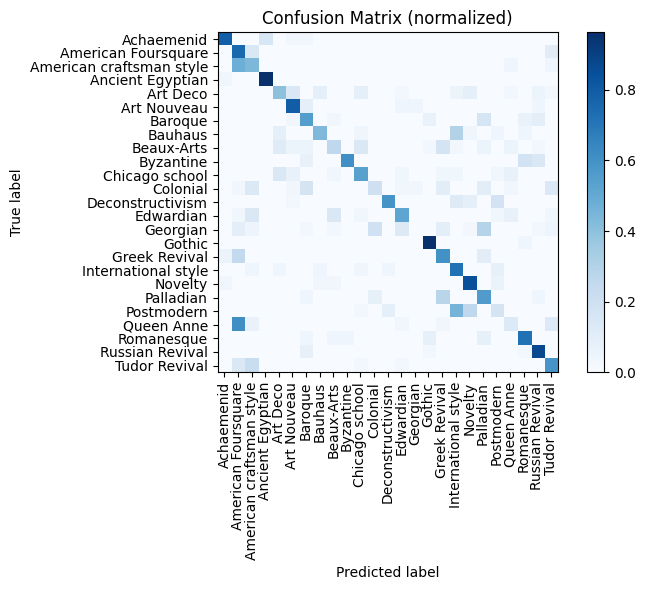

In [11]:
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    top_k_accuracy_score, ConfusionMatrixDisplay
)
import numpy as np
import matplotlib.pyplot as plt

num_classes = len(classnames)
y_true = y_true.astype(int)              # assicurati siano int 0..C-1
assert probs.shape[1] == num_classes, "probs deve avere una colonna per classe"

# Accuracy e report
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")
print(classification_report(y_true, y_pred, target_names=classnames, digits=4))

# Top-K
for k in [1, 2, 3, 5]:
    k = min(k, num_classes)
    topk = top_k_accuracy_score(
        y_true, probs, k=k, labels=np.arange(num_classes)
    )
    print(f"Top-{k} Accuracy: {topk:.4f}")

# Confusion Matrix (normalizzata)
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=classnames,
    normalize="true",           # percentuali per riga
    cmap="Blues",
    include_values=False,       # evita numeri sopra le celle se hai tante classi
    xticks_rotation=90,
    ax=ax,
    colorbar=True
)
ax.set_title("Confusion Matrix (normalized)")
plt.tight_layout()
plt.show()
